<a href="https://colab.research.google.com/github/ZahraShahlaie/Facial-emotion-recognition-with-yolo/blob/main/Facial_Emotion_Recognition_With_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Emotion Recognition**


**Author:** Zahra shahlaie  
**important and helpful sites :**

https://www.freecodecamp.org/news/how-to-detect-objects-in-images-using-yolov8/


https://github.com/akanametov/yolov8-face/tree/dev

https://colab.research.google.com/github/TUIlmenauAMS/Videocoding/blob/main/seminars/vc_seminar01_support.ipynb#scrollTo=pRXKyld_ium

https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=1nkSnkbkk4cC

https://universe.roboflow.com/lyanhvini/emotion-detection-a5i5h/dataset/4/images

https://github.com/ultralytics/ultralytics

In [ ]:
!pip install utils
!pip install kaggle
!pip install sentry-sdk
!pip install torch_utils
!pip install ultralytics
!pip install deep_sort_realtime


# clone repo
!git clone https://github.com/akanametov/yolov8-face

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_utils: filename=torch_utils-0.1.2-py3-none-any.whl size=6187 sha256=45efa17e107e21536d89c215faa9043988b7ab8ffd7b0a327cb16fd0a8a160fd
  Stored in directory: /root/.cache/pip/wheels/76/08/f0/378d1fe4aac5aa1e21483918d70b7e3428c4faaac0abda4e15
Successfully built torch_utils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 47.4 MB/s eta 0:00:00
Cloning into 'yolov8-face'...
remote: Enumerating objects: 3085, done.
remote: Total 3085 (delta 0), reused 0 (delta 0), pack-reused 3085
Receiving objects: 100% (3085/3085), 27.03 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (2061/2061), done.


## import dependencies

In [ ]:
import os
import io
import PIL
import cv2
import html
import time
import torch
import asyncio
import cv2 as cv
import numpy as np
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from typing import Union
from copy import deepcopy
from base64 import b64decode
from ultralytics import YOLO
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML
from tensorflow.keras import layers
from google.colab.output import eval_js
from base64 import b64encode , b64decode
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from ultralytics.utils.plotting import Annotator
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from deep_sort_realtime.deepsort_tracker import DeepSort
from IPython.display import display, Javascript, Image




# download and preparing dataset for emotion recognition

import kaggle.json in /content

**read kaggle.json file**

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
os.environ['KAGGLE_USERNAME']= 'zsh1999'
os.environ['KAGGLE_KEY']= '542959e4345bec7e802457964bbb42d8'


**download dataset**

In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset --force

 98% 118M/121M [00:06<00:00, 22.4MB/s]
100% 121M/121M [00:06<00:00, 19.3MB/s]


**Extract the downloaded file**

In [ ]:
import zipfile

# Replace 'path_to_zip_file.zip' with the actual path to your downloaded ZIP file
zip_file_path = '/content/face-expression-recognition-dataset.zip'

# Replace 'extracted_folder' with the desired name for the extracted folder
extracted_folder = '/content/Data'

# Create the target directory if it doesn't exist
import os
os.makedirs(extracted_folder, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print("ZIP file extracted successfully.")


ZIP file extracted successfully.


# **preprocessing Dataset**

In [ ]:
!rm -r /content/Data/images/images

In [ ]:
data_train_dir ='/content/Data/images/train'
data_valid_dir = '/content/Data/images/validation'



# **handling imbalanced data**

**Report from the count of images in train data**

In [ ]:
class_folder_names = []
num_images_in_folder = []

for class_folder in os.listdir(data_train_dir):
    class_folder_path = os.path.join(data_train_dir, class_folder)
    # Ensure the item in the directory is indeed a folder
    if os.path.isdir(class_folder_path):

     # List the files in the class folder
      files = os.listdir(class_folder_path)

      # Calculate how many files in each folder train set
      num_of_pic_in_folder = int(len(files))
      class_folder_names.append(class_folder)
      num_images_in_folder.append(num_of_pic_in_folder)

**Create the barplot**

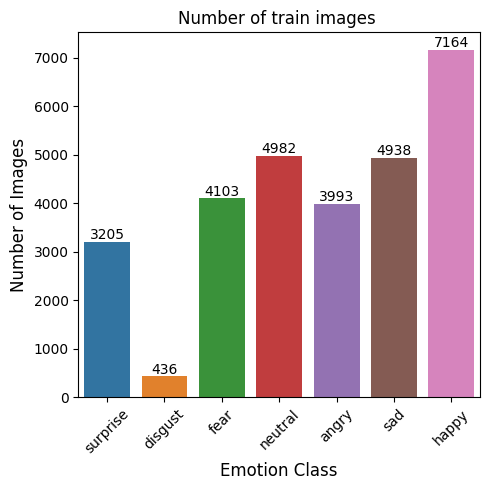

In [ ]:
# Create the barplot
plt.figure(figsize=(5, 5))
ax = sns.barplot(x=class_folder_names, y=num_images_in_folder, order=class_folder_names)

# Add annotations above each bar
for i, v in enumerate(num_images_in_folder):
    ax.text(i, v + 50, str(v), color='black', ha='center', fontsize=10)

plt.xlabel('Emotion Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of train images ', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**handling imbalanced  train data set**

In [ ]:

x_images = []
y_labels = []

for class_folder in os.listdir(data_train_dir):
    class_folder_path = os.path.join(data_train_dir, class_folder)
    for file_name in os.listdir(class_folder_path):
        file_path = os.path.join(class_folder_path, file_name)

        # read images
        img = cv2.imread(file_path)

        # Add image to image list
        x_images.append(img)

        # Add labels to labels list
        y_labels.append(class_folder)

x_images = np.array(x_images)
y_labels = np.array(y_labels)

#reshape x_images for preparing use in RandomOverSampler
x_images_reshaped = x_images.reshape(x_images.shape[0], -1)

ros = RandomOverSampler(sampling_strategy="not majority")

X_train_resampled, y_train_resampled = ros.fit_resample(x_images_reshaped, y_labels)

#reshape X_train_resampled
X_train_resampled = X_train_resampled.reshape(-1,48,48,3)

#print shapes
print(f"X_train_resampled : {X_train_resampled.shape}")
print(f"y_train_resampled : {y_train_resampled.shape}")


X_train_resampled : (50148, 48, 48, 3)
y_train_resampled : (50148,)


#----------------------------------------------------------------------------------------------------

**Report from the count of images in validation data**

In [ ]:
class_folder_names = []
num_images_in_folder = []

for class_folder in os.listdir(data_valid_dir):
    class_folder_path = os.path.join(data_valid_dir, class_folder)

    # Ensure the item in the directory is indeed a folder
    if os.path.isdir(class_folder_path):

     # List the files in the class folder
      files = os.listdir(class_folder_path)

      # Calculate how many files in each folder train set
      num_of_pic_in_folder = int(len(files))
      class_folder_names.append(class_folder)
      num_images_in_folder.append(num_of_pic_in_folder)


**Create the barplot**

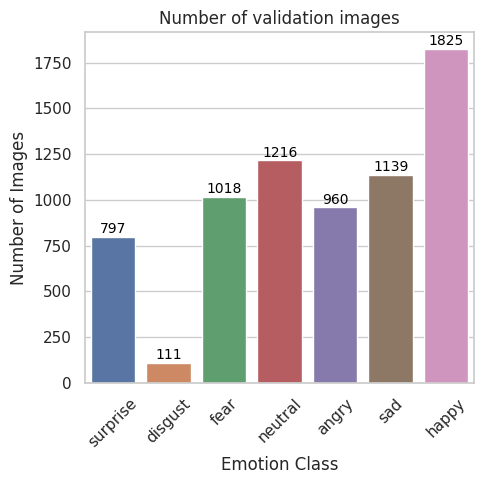

In [ ]:
# Create the barplot
plt.figure(figsize=(5, 5))
sns.set(style="whitegrid")
ax = sns.barplot(x=class_folder_names, y=num_images_in_folder, order=class_folder_names)

# Add annotations above each bar
for i, v in enumerate(num_images_in_folder):
    ax.text(i, v + 20, str(v), color='black', ha='center', fontsize=10)

plt.xlabel('Emotion Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of validation images', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**handling imbalanced  validation dataset**

In [ ]:

x_images = []
y_labels = []

for class_folder in os.listdir(data_valid_dir):
    class_folder_path = os.path.join(data_valid_dir, class_folder)
    for file_name in os.listdir(class_folder_path):
        file_path = os.path.join(class_folder_path, file_name)

        # read images
        img = cv2.imread(file_path)

        # Add image to image list
        x_images.append(img)

        # Add labels to labels list
        y_labels.append(class_folder)

x_images = np.array(x_images)
y_labels = np.array(y_labels)

#reshape x_images for preparing use in RandomOverSampler
x_images_reshaped = x_images.reshape(x_images.shape[0], -1)

ros = RandomOverSampler(sampling_strategy="not majority")

X_val_resampled, y_val_resampled = ros.fit_resample(x_images_reshaped, y_labels)

#reshape y_val_resampled
X_val_resampled = X_val_resampled.reshape(-1,48,48,3)

#print shapes
print(f"X_val_resampled : {X_val_resampled.shape}")
print(f"y_val_resampled : {y_val_resampled.shape}")


X_val_resampled : (12775, 48, 48, 3)
y_val_resampled : (12775,)


## **create dataset**

**X_train_resampled, y_train_resampled, X_val_resampled, y_val_resampled is ready for create a tensorflow dataset**

**LabelEncoder**

In [ ]:
label_encoder = LabelEncoder()

y_train_resampled_encode = label_encoder.fit_transform(y_train_resampled)

y_val_resampled_encode = label_encoder.transform(y_val_resampled)


In [ ]:
# Split a portion of training data for testing (10% of the training data)
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled_encode, test_size=0.1, random_state=42)

# Create a TensorFlow Dataset for training
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=len(X_train), seed=42).batch(32)

# Create a TensorFlow Dataset for validation
val_ds = tf.data.Dataset.from_tensor_slices((X_val_resampled, y_val_resampled_encode))
val_ds = val_ds.shuffle(buffer_size=len(X_val_resampled), seed=42).batch(32)

# Create a TensorFlow Dataset for testing
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.shuffle(buffer_size=len(X_test), seed=42).batch(32)



**Configure the dataset for performance**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**pint length of train ds and val ds an test ds**

In [ ]:
print("Train dataset size:", len(X_train))
print("Validation dataset size:", len(X_val_resampled))
print("Test dataset size:", len(X_test))


Train dataset size: 45133
Validation dataset size: 12775
Test dataset size: 5015


**count of each class**

In [ ]:
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_val, counts_val = np.unique(y_val_resampled, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

for class_id, count_train, count_val ,count_test in zip(unique_classes_val, counts_train,counts_val , counts_test):
    print(f"Class {class_id}: {count_train} samples in the training dataset, {count_val} in validation ,{count_test} in test ")


Class angry: 6434 samples in the training dataset, 1825 in validation ,730 in test 
Class disgust: 6434 samples in the training dataset, 1825 in validation ,730 in test 
Class fear: 6405 samples in the training dataset, 1825 in validation ,759 in test 
Class happy: 6457 samples in the training dataset, 1825 in validation ,707 in test 
Class neutral: 6477 samples in the training dataset, 1825 in validation ,687 in test 
Class sad: 6436 samples in the training dataset, 1825 in validation ,728 in test 
Class surprise: 6490 samples in the training dataset, 1825 in validation ,674 in test 


**show labels**

In [ ]:
class_names = np.unique(y_train_resampled)
class_names_length = len(class_names)
print(class_names)
print(class_names_length)


['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
7


In [ ]:
# Define constants
batch_size = 32
image_size = (48, 48)



**data_augmentation**

In [ ]:
# Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
    layers.RandomRotation(0.1),


  ]
)


In [ ]:
base_learning_rate = 0.0001

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            verbose=1)

## define model and train

In [ ]:
my_model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(class_names_length, activation='softmax' )
])

my_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_my_model = my_model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=60,
                    callbacks = [callback],
                    verbose = 1)

Epoch 1/60
1411/1411 [==============================] - 48s 24ms/step - loss: 1.8447 - accuracy: 0.2452 - val_loss: 1.6664 - val_accuracy: 0.3464
Epoch 2/60
1411/1411 [==============================] - 34s 24ms/step - loss: 1.6011 - accuracy: 0.3848 - val_loss: 1.4148 - val_accuracy: 0.4690
Epoch 3/60
1411/1411 [==============================] - 35s 25ms/step - loss: 1.4360 - accuracy: 0.4591 - val_loss: 1.3545 - val_accuracy: 0.5004
Epoch 4/60
1411/1411 [==============================] - 34s 24ms/step - loss: 1.3347 - accuracy: 0.4961 - val_loss: 1.2638 - val_accuracy: 0.5357
Epoch 5/60
1411/1411 [==============================] - 34s 24ms/step - loss: 1.2573 - accuracy: 0.5257 - val_loss: 1.2297 - val_accuracy: 0.5433
Epoch 6/60
1411/1411 [==============================] - 34s 24ms/step - loss: 1.1915 - accuracy: 0.5533 - val_loss: 1.2239 - val_accuracy: 0.5545
Epoch 7/60
1411/1411 [==============================] - 34s 24ms/step - loss: 1.1384 - accuracy: 0.5719 - val_loss: 1.1857 -

##Evaluate model

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, test_ds):
    results = model.evaluate(test_ds, verbose=0)
    loss = results[0]
    acc = results[1]

    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))



    # Extract the actual labels from the test dataset
    # Extract the prediction labels from the test dataset

    y_pred = []
    y_true = []

    for batch_images, batch_labels in test_ds:
       y_true.extend(batch_labels)
       batch_predictions = model.predict(batch_images)
       batch_pred_labels = np.argmax(batch_predictions, axis=1)
       y_pred.extend(batch_pred_labels)


    #creat confusion matrix
    confusion = confusion_matrix(y_true, y_pred)


    #plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    classification_rep = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n", classification_rep)

    return acc

    Test Loss: 0.88648
Test Accuracy: 67.06%
1/1 [==============================] - 0s 114ms/step


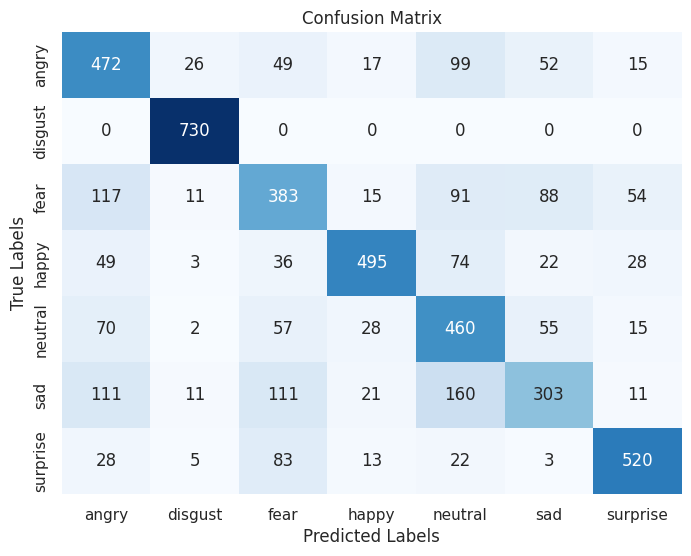

Classification Report:
               precision    recall  f1-score   support

       angry       0.56      0.65      0.60       730
     disgust       0.93      1.00      0.96       730
        fear       0.53      0.50      0.52       759
       happy       0.84      0.70      0.76       707
     neutral       0.51      0.67      0.58       687
         sad       0.58      0.42      0.48       728
    surprise       0.81      0.77      0.79       674

    accuracy                           0.67      5015
   macro avg       0.68      0.67      0.67      5015
weighted avg       0.68      0.67      0.67      5015



In [ ]:
acc_my_model=evaluate_model(my_model, test_ds)


## detect face

i want use a pre-trained model go to https://github.com/akanametov/yolov8-face/tree/dev and download yolov8n-face.pt and upload that in /content

In [ ]:
def detect_face(source_image):

    # detect face
    model = YOLO("/content/yolov8n-face.pt")
    result = model.predict(source_image)[0]

    face_detections = []
    det_confidences = []

    # Process detections
    if len(result.boxes):
       # Return results
       for box in result.boxes:
            class_id = result.names[box.cls[0].item()]
            cords = box.xyxy[0].tolist()
            cords = [round(x) for x in cords]
            conf = round(box.conf[0].item(), 2)

            face_detections.append(cords)
            det_confidences.append(conf)

    return face_detections, det_confidences


## crop detected faces

In [ ]:
def crop(image, coord):
    cropped_image = image[int(coord[1]):int(coord[3]), int(coord[0]):int(coord[2])]
    return cropped_image


## expression faces

In [ ]:
def expression_faces(face_detected):

  # Resize the image to the desired dimensions (e.g., 48x48 pixels)
  img = cv2.resize(face_detected, (48, 48))

  # Expand the dimensions to match the expected input shape (batch_size=1)
  img = np.expand_dims(img, axis=0)

  predictions = my_model.predict(img)

  score = tf.nn.softmax(predictions[0])

  print(f"predict : {class_names[np.argmax(score)]} , {round(100 * np.max(score),2)}")

  emotion_text = class_names[np.argmax(score)]
  emotion_confidence = round(100 * np.max(score),2)
  return emotion_text , emotion_confidence

## get facess from image

In [ ]:
def get_faces_from_image(input):
    if input is None:
        return None
    face_detections, det_confidences = detect_face(input)
    emotion_texts = []
    emotion_confidences = []
    detected_image = deepcopy(input)
    for coords in face_detections:
        face_region = crop(input, coords)
        emotion_text, emotion_confidence = expression_faces(face_region)
        emotion_texts.append(emotion_text)
        emotion_confidences.append(emotion_confidence)
        annotator = Annotator(detected_image)
        detected_image = annotator.box_label(coords, label=f"{emotion_text},{emotion_confidence}", color=(0, 0, 255), txt_color=(255, 255, 255))
        detected_image= annotator.result()
    return detected_image


## pascal voc to coco

In [ ]:
def pascal_voc_to_coco(x1y1x2y2):
    x1, y1, x2, y2 = x1y1x2y2
    return [x1, y1, x2 - x1, y2 - y1]


## get the best expression faces that are used in detecting faces from video

In [ ]:
def get_best_expression_faces(preds, emotion_confidence, emotion_text, track_id):

    for info in preds:
    # Check if it is current track id
        if info['track_id'] == track_id:
          # Check if the ocr confidenence is maximum or not
            if info['emotion_conf'] < emotion_confidence:
                info['emotion_conf'] = emotion_confidence
                info['emotion_txt'] = emotion_text
            else:
                emotion_confidence = info['emotion_conf']
                emotion_text = info['emotion_txt']
            break
    return preds, emotion_confidence, emotion_text

## get faces from video

In [ ]:

def get_faces_from_video(source):
    if source is None:
        return None

    # Create a VideoCapture object
    video = cv.VideoCapture(source)

    # Default resolutions of the frame are obtained. The default resolutions are system dependent.
    # We convert the resolutions from float to integer.
    width = int(video.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object.
    temp = f'{Path(source).stem}_temp{Path(source).suffix}'
    export = cv.VideoWriter(temp, cv.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    # Intializing tracker
    tracker = DeepSort()

    # Initializing some helper variables.
    preds = []
    total_obj = 0

    while(True):
        ret, frame = video.read()
        if ret == True:
            # Run the ANPR algorithm
            face_bboxes, det_confidences_faces = detect_face(frame)
            # Convert Pascal VOC detections to COCO
            face_bboxes = list(map(lambda face_bbox: pascal_voc_to_coco(face_bbox), face_bboxes))

            if len(face_bboxes) > 0:
                # Storing all the required info in a list.
                detections = [(face_bbox, det_confidence_face, 'number_face') for face_bbox, det_confidence_face in zip(face_bboxes, det_confidences_faces)]

                # Applying tracker.
                #Tracking the position and movement of detected objects in the image and updating tracking information in tracks
                tracks = tracker.update_tracks(detections, frame=frame)

                result = None

                # Checking if tracks exist.
                for track in tracks:
                    if not track.is_confirmed() or track.time_since_update > 1:
                        continue

                    # Changing track bbox to top left, bottom right coordinates
                    face_bbox = [int(position) for position in list(track.to_tlbr())]
                    result=[]
                    for i in range(len(face_bbox)):
                        if face_bbox[i] < 0:
                            face_bbox[i] = 0

                    # Cropping the license plate and applying the OCR.
                    face_region = crop(frame, face_bbox)
                    emotion_text, emotion_confidence = expression_faces(face_region)

                    # Storing the ocr output for corresponding track id.
                    output_frame = {'track_id': track.track_id, 'emotion_txt': emotion_text, 'emotion_conf': emotion_confidence}

                    # Appending track_id to list only if it does not exist in the list
                    # Tracking the position and movement of detected objects in the image and updating tracking information in tracks
                    if track.track_id not in list(set(pred['track_id'] for pred in preds)):
                        total_obj += 1
                        preds.append(output_frame)
                    else:
                        preds, emotion_confidence, emotion_text = get_best_expression_faces(preds, emotion_confidence, emotion_text, track.track_id)

                    # Plotting the prediction.
                    annotator = Annotator(frame)
                    frame = annotator.box_label(face_bbox, label=f'{emotion_text},{emotion_confidence}', color=(0, 0, 255), txt_color=(255, 255, 255))
                    frame = annotator.result()

            # Write the frame into the output file
            export.write(frame)
        else:
            break

    # When everything done, release the video capture and video write objects
    #cv.destroyAllWindows()
    video.release()
    export.release()

    # Compressing the output video for smaller size and web compatibility.
    output = f'{Path(source).stem}_detected{Path(source).suffix}'
    os.system(f'ffmpeg -y -i {temp} -c:v libx264 -b:v 5000k -minrate 1000k -maxrate 8000k -pass 1 -c:a aac -f mp4 /dev/null && ffmpeg -i {temp} -c:v libx264 -b:v 5000k -minrate 1000k -maxrate 8000k -pass 2 -c:a aac -movflags faststart {output}')
    os.system(f'rm -rf {temp} ffmpeg2pass-0.log ffmpeg2pass-0.log.mbtree')

    return output


## image and get_facess_from_image





WARNING ⚠️ /content/yolov8n-face.pt appears to require 'omegaconf', which is not in ultralytics requirements.
AutoInstall will run now for 'omegaconf' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['omegaconf'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=ec9893358ce3fb39832119b09423a8dfd9a76bc128500715c3f99cb15f620635
  Stored in directory: /tmp/pip-ephem-wheel-cache-n7mnppdk/wheels/12/93/dd/1f6a127edc45659556564c5

1/1 [==============================] - 0s 144ms/step
predict : happy , 25.38
1/1 [==============================] - 0s 21ms/step
predict : happy , 19.96
1/1 [==============================] - 0s 20ms/step
predict : happy , 30.01
1/1 [==============================] - 0s 20ms/step
predict : happy , 30.19
1/1 [==============================] - 0s 22ms/step
predict : neutral , 15.94
1/1 [==============================] - 0s 19ms/step
predict : neutral , 18.07


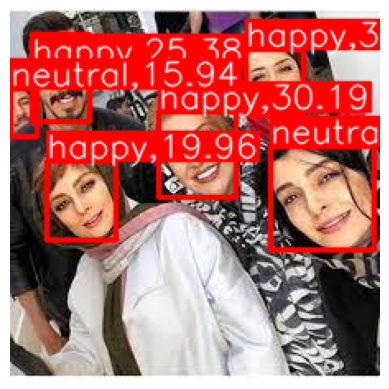

In [ ]:
#path of image that i want detect that
image_path = '/content/all-images-1.jpg'

#read image
img = cv.imread(image_path)

#detect image
de_img = get_faces_from_image(img)
de_img=cv.cvtColor(de_img, cv.COLOR_BGR2RGB)

# show image
plt.imshow(de_img)
plt.axis('off')
plt.show()


0: 640x448 1 face, 152.2ms
Speed: 2.6ms preprocess, 152.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 448)


1/1 [==============================] - 0s 31ms/step
predict : angry , 27.74


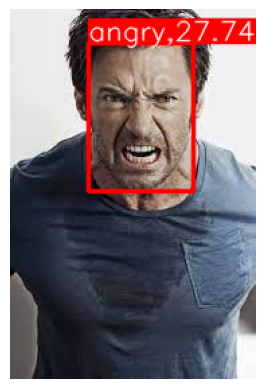

In [ ]:
#path of image that i want detect that
image_path = '/content/angry3.jpg'

#read image
img = cv.imread(image_path)

#detect image
de_img = get_faces_from_image(img)
de_img=cv.cvtColor(de_img, cv.COLOR_BGR2RGB)

# show image
plt.imshow(de_img)
plt.axis('off')
plt.show()


0: 384x640 1 face, 94.4ms
Speed: 1.7ms preprocess, 94.4ms inference, 11.2ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 42ms/step
predict : happy , 20.53


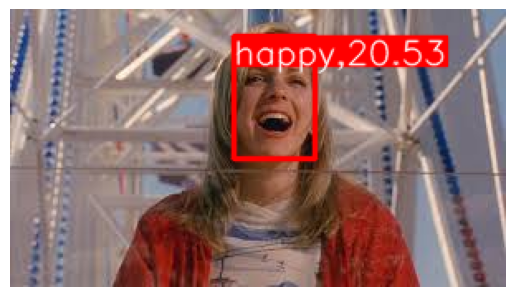

In [ ]:
#path of image that i want detect that
image_path = '/content/happy1.jpg'

#read image
img = cv.imread(image_path)

#detect image
de_img = get_faces_from_image(img)
de_img=cv.cvtColor(de_img, cv.COLOR_BGR2RGB)

# show image
plt.imshow(de_img)
plt.axis('off')
plt.show()


0: 480x640 1 face, 195.6ms
Speed: 2.4ms preprocess, 195.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step
predict : angry , 20.55


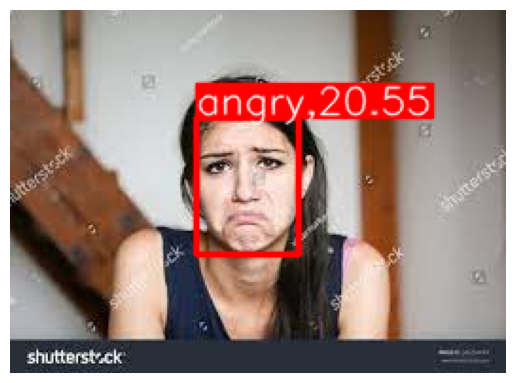

In [ ]:
#path of image that i want detect that
image_path = '/content/sad2.jpg'

#read image
img = cv.imread(image_path)

#detect image
de_img = get_faces_from_image(img)
de_img=cv.cvtColor(de_img, cv.COLOR_BGR2RGB)

# show image
plt.imshow(de_img)
plt.axis('off')
plt.show()


0: 288x640 2 faces, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)


1/1 [==============================] - 0s 37ms/step
predict : neutral , 17.76
1/1 [==============================] - 0s 19ms/step
predict : neutral , 16.13


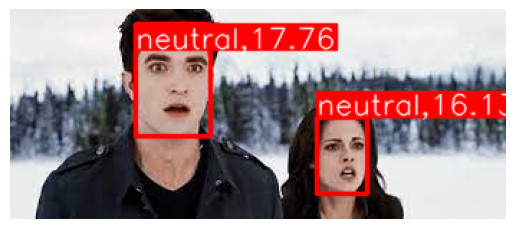

In [ ]:
#path of image that i want detect that
image_path = '/content/surprise3.jpg'

#read image
img = cv.imread(image_path)

#detect image
de_img = get_faces_from_image(img)
de_img=cv.cvtColor(de_img, cv.COLOR_BGR2RGB)

# show image
plt.imshow(de_img)
plt.axis('off')
plt.show()

## get_facess_from_video

In [ ]:
detected_face_image= get_faces_from_video("/content/video_3.mp4")



0: 640x384 1 face, 91.4ms
Speed: 2.0ms preprocess, 91.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 face, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 face, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 38ms/step
predict : neutral , 18.43



0: 640x384 1 face, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step
predict : neutral , 18.33



0: 640x384 1 face, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step
predict : neutral , 18.22



0: 640x384 1 face, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step
predict : sad , 17.98



0: 640x384 1 face, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step
predict : sad , 18.4



0: 640x384 1 face, 12.7ms
Speed: 2.4ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 56ms/step
predict : sad , 18.15



0: 640x384 1 face, 17.6ms
Speed: 3.3ms preprocess, 17.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 38ms/step
predict : sad , 18.66



0: 640x384 1 face, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 36ms/step


predict : sad , 18.69


0: 640x384 1 face, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 18.79
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.01
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.13
1/1 [==============================] - 0s 36ms/step



0: 640x384 1 face, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.23
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.41
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.47
1/1 [==============================] - 0s 35ms/step



0: 640x384 1 face, 8.0ms


predict : sad , 19.31


Speed: 1.8ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.46
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.56
1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.74
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.97
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.88
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.76
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.74
1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.73
1/1 [==============================] - 0s 25ms/step



0: 640x384 2 faces, 10.3ms
Speed: 1.8ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 19.73
1/1 [==============================] - 0s 25ms/step



0: 640x384 2 faces, 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 16.5



0: 640x384 2 faces, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step
predict : sad , 24.45
1/1 [==============================] - 0s 20ms/step
predict : neutral , 18.51



0: 640x384 2 faces, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step
predict : sad , 24.51
1/1 [==============================] - 0s 24ms/step
predict : neutral , 18.98



0: 640x384 2 faces, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step
predict : sad , 24.59
1/1 [==============================] - 0s 24ms/step
predict : angry , 26.1



0: 640x384 2 faces, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step
predict : sad , 24.55
1/1 [==============================] - 0s 19ms/step
predict : angry , 28.94



0: 640x384 2 faces, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 47ms/step
predict : sad , 24.54
1/1 [==============================] - 0s 20ms/step
predict : angry , 25.57



0: 640x384 2 faces, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step
predict : sad , 24.35
1/1 [==============================] - 0s 20ms/step
predict : angry , 18.67



0: 640x384 2 faces, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step
predict : sad , 24.51
1/1 [==============================] - 0s 19ms/step
predict : sad , 18.56



0: 640x384 2 faces, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step
predict : sad , 24.1
1/1 [==============================] - 0s 21ms/step
predict : sad , 18.2



0: 640x384 2 faces, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step
predict : sad , 24.38
1/1 [==============================] - 0s 21ms/step
predict : sad , 18.5



0: 640x384 2 faces, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step
predict : sad , 24.22
1/1 [==============================] - 0s 23ms/step
predict : sad , 17.77



0: 640x384 2 faces, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 25ms/step
predict : sad , 24.33
1/1 [==============================] - 0s 20ms/step
predict : happy , 16.98



0: 640x384 2 faces, 9.2ms
Speed: 1.9ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step
predict : sad , 24.07
1/1 [==============================] - 0s 22ms/step
predict : angry , 16.35



0: 640x384 2 faces, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step
predict : sad , 23.96
1/1 [==============================] - 0s 22ms/step
predict : sad , 17.53



0: 640x384 2 faces, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 195ms/step
predict : sad , 23.86
1/1 [==============================] - 0s 169ms/step
predict : sad , 17.07



0: 640x384 2 faces, 13.7ms
Speed: 2.9ms preprocess, 13.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 215ms/step
predict : sad , 24.3
1/1 [==============================] - 0s 83ms/step
predict : sad , 17.62



0: 640x384 2 faces, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 20ms/step
predict : sad , 23.77
1/1 [==============================] - 0s 20ms/step
predict : angry , 17.87



0: 640x384 2 faces, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 34ms/step
predict : sad , 24.4
1/1 [==============================] - 0s 18ms/step
predict : angry , 18.46



0: 640x384 2 faces, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step
predict : sad , 24.1
1/1 [==============================] - 0s 23ms/step
predict : sad , 18.36



0: 640x384 2 faces, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 25ms/step
predict : sad , 24.17
1/1 [==============================] - 0s 18ms/step
predict : angry , 18.82



0: 640x384 2 faces, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step
predict : sad , 24.29
1/1 [==============================] - 0s 20ms/step
predict : angry , 17.55



0: 640x384 2 faces, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step
predict : sad , 23.98
1/1 [==============================] - 0s 20ms/step
predict : angry , 17.22



0: 640x384 2 faces, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step
predict : sad , 24.24
1/1 [==============================] - 0s 21ms/step
predict : sad , 17.39



0: 640x384 2 faces, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 25ms/step
predict : sad , 24.29
1/1 [==============================] - 0s 22ms/step
predict : angry , 17.43



0: 640x384 2 faces, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step
predict : sad , 24.46
1/1 [==============================] - 0s 21ms/step
predict : sad , 17.68



0: 640x384 2 faces, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step
predict : sad , 23.87
1/1 [==============================] - 0s 21ms/step
predict : sad , 18.24



0: 640x384 2 faces, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step
predict : sad , 23.05
1/1 [==============================] - 0s 28ms/step
predict : sad , 18.27



0: 640x384 2 faces, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 34ms/step
predict : sad , 22.79
1/1 [==============================] - 0s 21ms/step
predict : sad , 18.85



0: 640x384 2 faces, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step
predict : sad , 23.17
1/1 [==============================] - 0s 21ms/step
predict : sad , 18.54



0: 640x384 2 faces, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step
predict : sad , 23.59
1/1 [==============================] - 0s 20ms/step
predict : sad , 17.56



0: 640x384 2 faces, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step
predict : sad , 23.92
1/1 [==============================] - 0s 19ms/step
predict : angry , 19.51



0: 640x384 2 faces, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step
predict : sad , 23.61
1/1 [==============================] - 0s 20ms/step
predict : angry , 19.57



0: 640x384 2 faces, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step
predict : sad , 23.2
1/1 [==============================] - 0s 22ms/step
predict : angry , 18.97



0: 640x384 2 faces, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step
predict : sad , 23.49
1/1 [==============================] - 0s 24ms/step
predict : sad , 18.73



0: 640x384 2 faces, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 40ms/step
predict : sad , 23.5
1/1 [==============================] - 0s 21ms/step
predict : sad , 20.24



0: 640x384 2 faces, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step
predict : sad , 23.49
1/1 [==============================] - 0s 24ms/step
predict : sad , 20.44



0: 640x384 2 faces, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 25ms/step
predict : sad , 23.28
1/1 [==============================] - 0s 25ms/step
predict : sad , 19.79



0: 640x384 2 faces, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step
predict : sad , 23.15
1/1 [==============================] - 0s 19ms/step
predict : sad , 19.86



0: 640x384 2 faces, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step
predict : sad , 23.23
1/1 [==============================] - 0s 23ms/step
predict : sad , 19.17



0: 640x384 2 faces, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step
predict : sad , 22.74
1/1 [==============================] - 0s 24ms/step
predict : sad , 18.74



0: 640x384 2 faces, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step
predict : sad , 22.47
1/1 [==============================] - 0s 20ms/step
predict : sad , 18.2



0: 640x384 2 faces, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 25ms/step
predict : sad , 22.36
1/1 [==============================] - 0s 22ms/step
predict : sad , 16.76



0: 640x384 2 faces, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step
predict : sad , 21.77
1/1 [==============================] - 0s 19ms/step
predict : sad , 17.22



0: 640x384 2 faces, 11.2ms
Speed: 2.1ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 57ms/step
predict : sad , 21.76
1/1 [==============================] - 0s 29ms/step
predict : sad , 18.65



0: 640x384 2 faces, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 62ms/step
predict : sad , 21.75
1/1 [==============================] - 0s 29ms/step
predict : sad , 18.64



0: 640x384 2 faces, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 46ms/step
predict : sad , 21.8
1/1 [==============================] - 0s 32ms/step
predict : sad , 18.17



0: 640x384 2 faces, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 39ms/step
predict : sad , 21.45
1/1 [==============================] - 0s 30ms/step
predict : sad , 16.16



0: 640x384 2 faces, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 46ms/step
predict : sad , 20.98
1/1 [==============================] - 0s 32ms/step
predict : angry , 16.56



0: 640x384 2 faces, 14.5ms
Speed: 2.2ms preprocess, 14.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step
predict : sad , 20.71
1/1 [==============================] - 0s 23ms/step
predict : angry , 16.19



0: 640x384 2 faces, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 38ms/step
predict : sad , 20.08
1/1 [==============================] - 0s 21ms/step
predict : neutral , 16.46



0: 640x384 2 faces, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step
predict : sad , 19.72
1/1 [==============================] - 0s 21ms/step
predict : angry , 16.23



0: 640x384 2 faces, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step
predict : sad , 20.0
1/1 [==============================] - 0s 20ms/step
predict : angry , 16.51



0: 640x384 1 face, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step
predict : fear , 17.99
1/1 [==============================] - 0s 22ms/step
predict : sad , 15.91



0: 640x384 1 face, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 face, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step


predict : angry , 23.02


0: 640x384 1 face, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 21ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 22.89
1/1 [==============================] - 0s 19ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 22.44
1/1 [==============================] - 0s 20ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 22.7
1/1 [==============================] - 0s 36ms/step


predict : angry , 22.55


0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 8.6ms
Speed: 1.8ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 22.62
1/1 [==============================] - 0s 29ms/step
predict : angry , 21.93



0: 640x384 1 face, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 21.26
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 20.97
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 21.6
1/1 [==============================] - 0s 57ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 21.4
1/1 [==============================] - 0s 34ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 18.35
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.53
1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.55
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 17.63
1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.6
1/1 [==============================] - 0s 32ms/step


predict : sad , 17.87


0: 640x384 1 face, 8.9ms
Speed: 1.9ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 42ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.92
1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.38
1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.9ms


predict : sad , 16.8


Speed: 1.8ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step


predict : sad , 16.58


0: 640x384 1 face, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 16.53
1/1 [==============================] - 0s 25ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 16.59
1/1 [==============================] - 0s 26ms/step


predict : angry , 17.07


0: 640x384 1 face, 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 17.75
1/1 [==============================] - 0s 24ms/step



0: 640x384 1 face, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 17.52
1/1 [==============================] - 0s 31ms/step
predict : angry , 16.27


In [ ]:
detected_face_image_2= get_faces_from_video("/content/video_1.mp4")



0: 640x384 1 face, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 face, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 face, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 21ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 20.34
1/1 [==============================] - 0s 19ms/step



0: 640x384 1 face, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 19.56
1/1 [==============================] - 0s 22ms/step



0: 640x384 1 face, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 19.32
1/1 [==============================] - 0s 21ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 22.53
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 24.39
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 25.82
1/1 [==============================] - 0s 50ms/step



0: 640x384 1 face, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 25.61
1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 25.25
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 26.53
1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 23.78
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 23.85
1/1 [==============================] - 0s 27ms/step
predict : happy , 26.0



0: 640x384 1 face, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 24.49
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 9.9ms


predict : happy , 26.61


Speed: 1.9ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 36ms/step



0: 640x384 1 face, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 26.44
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 26.39
1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 27.6
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 27.27
1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 25.92
1/1 [==============================] - 0s 28ms/step


predict : happy , 26.84


0: 640x384 1 face, 9.1ms
Speed: 1.8ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step
predict : happy , 26.17



0: 640x384 1 face, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 43ms/step
predict : happy , 24.21



0: 640x384 1 face, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 52ms/step
predict : happy , 26.24



0: 640x384 1 face, 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step
predict : happy , 25.92



0: 640x384 1 face, 18.5ms
Speed: 2.2ms preprocess, 18.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step
predict : happy , 25.34



0: 640x384 1 face, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step
predict : happy , 26.34



0: 640x384 1 face, 14.2ms
Speed: 2.0ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 43ms/step
predict : happy , 25.75



0: 640x384 1 face, 14.7ms
Speed: 2.2ms preprocess, 14.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 38ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 26.55
1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 26.66
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 26.37
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 25.07
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 22.33
1/1 [==============================] - 0s 32ms/step


predict : happy , 22.49


0: 640x384 1 face, 14.7ms
Speed: 2.1ms preprocess, 14.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 19.75
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 21.8
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 23.35
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 25.1
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 8.9ms
Speed: 1.8ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 24.71
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 25.26
1/1 [==============================] - 0s 27ms/step


predict : neutral , 25.01


0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 24.27
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 8.0ms


predict : neutral , 24.06


Speed: 1.8ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 24.04
1/1 [==============================] - 0s 34ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 23.33
1/1 [==============================] - 0s 28ms/step


predict : neutral , 23.49


0: 640x384 1 face, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 22.92
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 21.82
1/1 [==============================] - 0s 30ms/step


predict : neutral , 21.48


0: 640x384 1 face, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 20.78
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 21.49
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 23.31
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 23.69
1/1 [==============================] - 0s 25ms/step



0: 640x384 1 face, 7.7ms


predict : neutral , 24.73


Speed: 1.8ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 24.86
1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 25.28
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.5ms


predict : neutral , 25.2


Speed: 1.8ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step


predict : neutral , 24.79


0: 640x384 1 face, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 25.02
1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 9.0ms
Speed: 1.8ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 24.1
1/1 [==============================] - 0s 25ms/step



0: 640x384 1 face, 7.9ms


predict : neutral , 24.32


Speed: 1.7ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.4ms


predict : neutral , 23.62


Speed: 1.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 40ms/step
predict : neutral , 22.74



0: 640x384 1 face, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 44ms/step
predict : neutral , 22.49



0: 640x384 1 face, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 51ms/step
predict : neutral , 22.0



0: 640x384 1 face, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 74ms/step
predict : neutral , 21.29



0: 640x384 1 face, 10.1ms
Speed: 2.1ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 42ms/step
predict : neutral , 20.31



0: 640x384 1 face, 13.7ms
Speed: 3.2ms preprocess, 13.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 42ms/step
predict : neutral , 20.41



0: 640x384 1 face, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 38ms/step
predict : neutral , 21.41



0: 640x384 1 face, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 19.02



0: 640x384 1 face, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.46
1/1 [==============================] - 0s 19ms/step



0: 640x384 1 face, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.54
1/1 [==============================] - 0s 21ms/step



0: 640x384 1 face, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.28
1/1 [==============================] - 0s 19ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.05
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.01
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.03
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.06
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.4
1/1 [==============================] - 0s 30ms/step


predict : angry , 19.07


0: 640x384 1 face, 9.3ms
Speed: 1.8ms preprocess, 9.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.53
1/1 [==============================] - 0s 27ms/step


predict : angry , 20.21


0: 640x384 1 face, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 15.1ms
Speed: 2.1ms preprocess, 15.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.61
1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 20.03
1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 21.28
1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 21.77
1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 7.8ms


predict : angry , 22.27


Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 22.72
1/1 [==============================] - 0s 30ms/step


predict : angry , 22.71


0: 640x384 1 face, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step


predict : angry , 23.09


0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 22.64
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 22.02
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 22.38
1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.5ms


predict : angry , 24.23


Speed: 1.9ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step


predict : angry , 24.21


0: 640x384 1 face, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step


predict : angry , 25.24


0: 640x384 1 face, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step


predict : angry , 26.42


0: 640x384 1 face, 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step


predict : angry , 25.46


0: 640x384 1 face, 8.7ms
Speed: 1.8ms preprocess, 8.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 25.38
1/1 [==============================] - 0s 33ms/step


predict : angry , 24.55


0: 640x384 1 face, 13.5ms
Speed: 2.1ms preprocess, 13.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 24.03
1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 24.17
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 24.78
1/1 [==============================] - 0s 26ms/step
predict : angry , 24.99



0: 640x384 1 face, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step
predict : angry , 24.56



0: 640x384 1 face, 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step
predict : sad , 16.8



0: 640x384 1 face, 10.7ms
Speed: 2.2ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 41ms/step
predict : sad , 17.88



0: 640x384 1 face, 13.9ms
Speed: 2.2ms preprocess, 13.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 34ms/step
predict : sad , 17.53



0: 640x384 1 face, 14.3ms
Speed: 2.4ms preprocess, 14.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 47ms/step
predict : sad , 17.32



0: 640x384 1 face, 14.8ms
Speed: 2.3ms preprocess, 14.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 36ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.37
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 16.91
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 8.5ms


predict : sad , 17.07


Speed: 2.1ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step


predict : sad , 17.21


0: 640x384 1 face, 15.0ms
Speed: 2.2ms preprocess, 15.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 42ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.27
1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 7.9ms


predict : sad , 17.03


Speed: 1.8ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 16.8
1/1 [==============================] - 0s 34ms/step



0: 640x384 1 face, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 16.79
1/1 [==============================] - 0s 29ms/step


predict : neutral , 17.11


0: 640x384 1 face, 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.03
1/1 [==============================] - 0s 32ms/step


predict : neutral , 17.07


0: 640x384 1 face, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.27
1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.74
1/1 [==============================] - 0s 25ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.91
1/1 [==============================] - 0s 37ms/step



0: 640x384 1 face, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.85
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.37
1/1 [==============================] - 0s 35ms/step



0: 640x384 1 face, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.2
1/1 [==============================] - 0s 35ms/step


predict : neutral , 17.29


0: 640x384 1 face, 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.53
1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 8.9ms


predict : neutral , 17.49


Speed: 1.9ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 25ms/step



0: 640x384 1 face, 13.9ms


predict : neutral , 17.39


Speed: 2.1ms preprocess, 13.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.46
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 8.2ms


predict : neutral , 17.43


Speed: 1.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.57
1/1 [==============================] - 0s 32ms/step


predict : neutral , 17.44


0: 640x384 1 face, 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.55
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.65
1/1 [==============================] - 0s 34ms/step


predict : neutral , 17.74


0: 640x384 1 face, 10.4ms
Speed: 2.8ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.9ms


predict : neutral , 17.82


Speed: 1.8ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.82
1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.73
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.93
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 18.14
1/1 [==============================] - 0s 41ms/step
predict : neutral , 18.34



0: 640x384 1 face, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 38ms/step
predict : neutral , 17.73



0: 640x384 1 face, 12.6ms
Speed: 2.4ms preprocess, 12.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 50ms/step
predict : neutral , 17.57



0: 640x384 1 face, 13.4ms
Speed: 2.3ms preprocess, 13.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 44ms/step
predict : neutral , 17.46



0: 640x384 1 face, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 58ms/step
predict : neutral , 17.46



0: 640x384 1 face, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 44ms/step
predict : neutral , 17.47



0: 640x384 1 face, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 39ms/step
predict : neutral , 17.51



0: 640x384 1 face, 13.5ms
Speed: 2.1ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 25ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.19
1/1 [==============================] - 0s 43ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.5
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.43
1/1 [==============================] - 0s 36ms/step


predict : neutral , 17.02


0: 640x384 1 face, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step


predict : sad , 16.96


0: 640x384 1 face, 8.4ms
Speed: 4.6ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 34ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.16
1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.22
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.8ms


predict : sad , 17.1


Speed: 1.7ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step


predict : sad , 17.29


0: 640x384 1 face, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step


predict : sad , 17.22


0: 640x384 1 face, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 41ms/step
predict : sad , 17.33



0: 640x384 1 face, 11.1ms
Speed: 2.3ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.43
1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.7ms


predict : sad , 17.36


Speed: 1.9ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.24
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.22
1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : sad , 17.21
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 16.94
1/1 [==============================] - 0s 27ms/step


predict : sad , 17.02


0: 640x384 1 face, 9.1ms
Speed: 1.9ms preprocess, 9.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.24
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : neutral , 17.24
1/1 [==============================] - 0s 34ms/step


predict : sad , 19.28


0: 640x384 1 face, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 face, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 25.1
1/1 [==============================] - 0s 20ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 24.14
1/1 [==============================] - 0s 20ms/step



0: 640x384 1 face, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 24.42
1/1 [==============================] - 0s 21ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 24.04
1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 24.6
1/1 [==============================] - 0s 32ms/step


predict : angry , 20.77


0: 640x384 1 face, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step


predict : angry , 20.79


0: 640x384 1 face, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 21.23
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.94
1/1 [==============================] - 0s 27ms/step


predict : angry , 20.42


0: 640x384 1 face, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step


predict : angry , 22.55


0: 640x384 1 face, 12.8ms
Speed: 2.5ms preprocess, 12.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 36ms/step
predict : angry , 20.74



0: 640x384 1 face, 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 44ms/step
predict : angry , 23.34



0: 640x384 1 face, 21.3ms
Speed: 2.2ms preprocess, 21.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 90ms/step
predict : angry , 20.15



0: 640x384 1 face, 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 60ms/step
predict : angry , 19.33



0: 640x384 1 face, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 47ms/step
predict : angry , 19.63



0: 640x384 1 face, 14.2ms
Speed: 2.3ms preprocess, 14.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step
predict : angry , 19.73



0: 640x384 1 face, 14.6ms
Speed: 2.1ms preprocess, 14.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 38ms/step
predict : angry , 19.17



0: 640x384 1 face, 14.9ms
Speed: 2.5ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.5ms


predict : angry , 19.64


Speed: 1.8ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 20.0
1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 7.7ms


predict : angry , 20.4


Speed: 1.8ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step


predict : angry , 20.31


0: 640x384 1 face, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step


predict : angry , 20.42


0: 640x384 1 face, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 37ms/step


predict : angry , 19.86


0: 640x384 1 face, 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.3
1/1 [==============================] - 0s 26ms/step


predict : angry , 19.15


0: 640x384 1 face, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step


predict : angry , 19.71


0: 640x384 1 face, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.54
1/1 [==============================] - 0s 25ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.89
1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 18.95
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.56
1/1 [==============================] - 0s 29ms/step
predict : angry , 19.14



0: 640x384 1 face, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 18.79
1/1 [==============================] - 0s 34ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 17.71
1/1 [==============================] - 0s 27ms/step


predict : angry , 18.59


0: 640x384 1 face, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 36ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 18.83
1/1 [==============================] - 0s 33ms/step


predict : angry , 17.97


0: 640x384 1 face, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 38ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 17.96
1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 17.82
1/1 [==============================] - 0s 37ms/step


predict : angry , 18.63


0: 640x384 1 face, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.17
1/1 [==============================] - 0s 35ms/step


predict : angry , 19.63


0: 640x384 1 face, 11.1ms
Speed: 1.7ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.72
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 21.65
1/1 [==============================] - 0s 25ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 20.85
1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.9ms


predict : angry , 19.54


Speed: 1.7ms preprocess, 7.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.74
1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 19.42
1/1 [==============================] - 0s 34ms/step


predict : angry , 18.99


0: 640x384 1 face, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 18.72
1/1 [==============================] - 0s 31ms/step
predict : angry , 18.88



0: 640x384 1 face, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 48ms/step
predict : angry , 19.54



0: 640x384 1 face, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 49ms/step
predict : angry , 19.45



0: 640x384 1 face, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 66ms/step
predict : angry , 19.28



0: 640x384 1 face, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 60ms/step
predict : angry , 18.44



0: 640x384 1 face, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 37ms/step
predict : angry , 18.34



0: 640x384 1 face, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 35ms/step
predict : angry , 18.23



0: 640x384 1 face, 13.9ms
Speed: 2.0ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 41ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 17.98
1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : angry , 18.92
1/1 [==============================] - 0s 29ms/step


predict : angry , 27.27


0: 640x384 1 face, 11.2ms
Speed: 2.1ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 face, 8.6ms
Speed: 1.8ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step


predict : happy , 25.83


0: 640x384 1 face, 17.0ms
Speed: 2.2ms preprocess, 17.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 21ms/step



0: 640x384 1 face, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 26.47
1/1 [==============================] - 0s 20ms/step



0: 640x384 1 face, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 26.92
1/1 [==============================] - 0s 20ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 27.48
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 27.51
1/1 [==============================] - 0s 31ms/step


predict : happy , 27.78


0: 640x384 1 face, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 34ms/step


predict : happy , 27.72


0: 640x384 1 face, 9.4ms
Speed: 1.8ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step


predict : happy , 28.32


0: 640x384 1 face, 10.5ms
Speed: 2.8ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step


predict : happy , 28.4


0: 640x384 1 face, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step


predict : happy , 28.36


0: 640x384 1 face, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 8.4ms


predict : happy , 28.75


Speed: 1.8ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step


predict : happy , 28.25


0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 28.83
1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 28.87
1/1 [==============================] - 0s 27ms/step


predict : happy , 29.47


0: 640x384 1 face, 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 29.29
1/1 [==============================] - 0s 28ms/step



0: 640x384 1 face, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 29.63
1/1 [==============================] - 0s 27ms/step


predict : happy , 29.76


0: 640x384 1 face, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 29.74
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 29.65
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 29.55
1/1 [==============================] - 0s 26ms/step


predict : happy , 29.54


0: 640x384 1 face, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step


predict : happy , 29.31


0: 640x384 1 face, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 8.0ms
Speed: 1.7ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 28.91
1/1 [==============================] - 0s 27ms/step


predict : happy , 29.6


0: 640x384 1 face, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 29.78
1/1 [==============================] - 0s 33ms/step


predict : happy , 29.73


0: 640x384 1 face, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 26ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 29.54
1/1 [==============================] - 0s 26ms/step


predict : happy , 29.25


0: 640x384 1 face, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 35ms/step


predict : happy , 29.32


0: 640x384 1 face, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 60ms/step
predict : happy , 28.43



0: 640x384 1 face, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 35ms/step
predict : happy , 28.61



0: 640x384 1 face, 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 62ms/step
predict : happy , 29.39



0: 640x384 1 face, 14.4ms
Speed: 2.2ms preprocess, 14.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 67ms/step
predict : happy , 30.22



0: 640x384 1 face, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 45ms/step
predict : happy , 30.63



0: 640x384 1 face, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 68ms/step
predict : happy , 30.72



0: 640x384 1 face, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 42ms/step
predict : happy , 30.46



0: 640x384 1 face, 16.5ms
Speed: 2.3ms preprocess, 16.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step


predict : happy , 30.41


0: 640x384 1 face, 10.9ms
Speed: 1.8ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 35ms/step



0: 640x384 1 face, 9.1ms


predict : happy , 30.5


Speed: 1.9ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 30.25
1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 29.86
1/1 [==============================] - 0s 28ms/step


predict : happy , 29.77


0: 640x384 1 face, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 29.81
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 9.1ms


predict : happy , 29.88


Speed: 2.0ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 30ms/step



0: 640x384 1 face, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 29.88
1/1 [==============================] - 0s 27ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 30.27
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 30.23
1/1 [==============================] - 0s 29ms/step


predict : happy , 30.38


0: 640x384 1 face, 12.9ms
Speed: 1.7ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 36ms/step


predict : happy , 30.46


0: 640x384 1 face, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 33ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 29.98
1/1 [==============================] - 0s 27ms/step


predict : happy , 30.0


0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 35ms/step


predict : happy , 30.14


0: 640x384 1 face, 16.1ms
Speed: 2.2ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 30.01
1/1 [==============================] - 0s 26ms/step


predict : happy , 30.12


0: 640x384 1 face, 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 28ms/step
predict : happy , 30.47



0: 640x384 1 face, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 52ms/step



0: 640x384 1 face, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 30.34
1/1 [==============================] - 0s 32ms/step


predict : happy , 30.47


0: 640x384 1 face, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 43ms/step



0: 640x384 1 face, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 30.5
1/1 [==============================] - 0s 29ms/step



0: 640x384 1 face, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 30.55
1/1 [==============================] - 0s 30ms/step


predict : happy , 30.43


0: 640x384 1 face, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 38ms/step


predict : happy , 29.73


0: 640x384 1 face, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 29ms/step


predict : happy , 29.79


0: 640x384 1 face, 14.3ms
Speed: 1.7ms preprocess, 14.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step


predict : happy , 29.74


0: 640x384 1 face, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 34ms/step


predict : happy , 30.33


0: 640x384 1 face, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 31ms/step



0: 640x384 1 face, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 30.49
1/1 [==============================] - 0s 29ms/step


predict : happy , 30.47


0: 640x384 1 face, 13.1ms
Speed: 1.8ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 34ms/step



0: 640x384 1 face, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 30.61
1/1 [==============================] - 0s 35ms/step



0: 640x384 1 face, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 30.11
1/1 [==============================] - 0s 37ms/step
predict : happy , 30.1



0: 640x384 1 face, 13.0ms
Speed: 2.2ms preprocess, 13.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 48ms/step
predict : happy , 30.36



0: 640x384 1 face, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 45ms/step
predict : happy , 30.48



0: 640x384 1 face, 16.9ms
Speed: 2.1ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step
predict : happy , 30.47



0: 640x384 1 face, 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 42ms/step
predict : happy , 30.47



0: 640x384 1 face, 13.8ms
Speed: 2.1ms preprocess, 13.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 54ms/step
predict : happy , 30.65



0: 640x384 1 face, 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 37ms/step
predict : happy , 30.48



0: 640x384 1 face, 14.1ms
Speed: 2.0ms preprocess, 14.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 69ms/step
predict : happy , 27.16



0: 640x384 1 face, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 32ms/step


predict : happy , 28.91


0: 640x384 1 face, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


1/1 [==============================] - 0s 34ms/step



0: 640x384 1 face, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 27.67
1/1 [==============================] - 0s 32ms/step



0: 640x384 1 face, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


predict : happy , 23.09
1/1 [==============================] - 0s 34ms/step
predict : angry , 17.52


## display_video

In [ ]:
mp4 = open(detected_face_image,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
mp4 = open(detected_face_image_2,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## use webcam

helper function

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)


def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Webcam Images


In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

  de_img = get_faces_from_image(img)

  # save image
  cv2.imwrite(filename, de_img)

  return filename

**Click Capture and  see the expression emotional  detected face**

<IPython.core.display.Javascript object>


0: 480x640 2 faces, 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 35ms/step
predict : neutral , 23.82
1/1 [==============================] - 0s 18ms/step
predict : sad , 17.25
Saved to photo.jpg


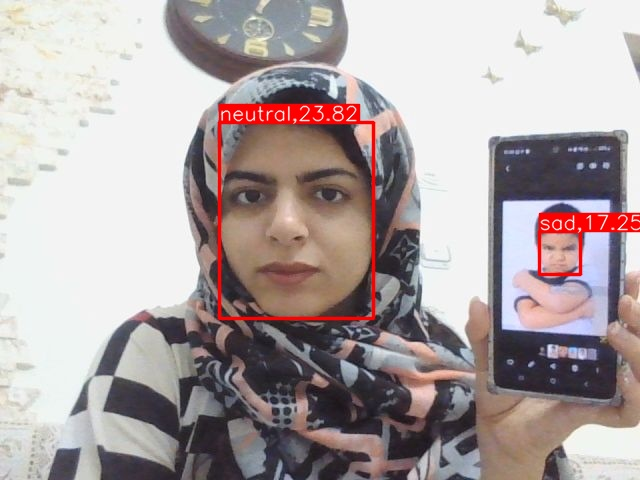

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>


0: 480x640 2 faces, 22.2ms
Speed: 2.9ms preprocess, 22.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 36ms/step
predict : happy , 27.45
1/1 [==============================] - 0s 30ms/step
predict : surprise , 23.65
Saved to photo.jpg


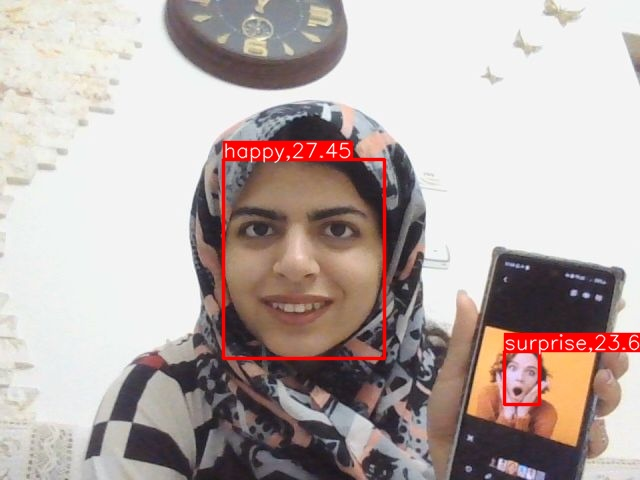

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Webcam Videos


In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''
count = 0
while True:

    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Intializing tracker
    tracker = DeepSort()

    # Initializing some helper variables.
    preds = []
    total_obj = 0
    temp = f'cam_temp.mp4'

    # Run the ANPR algorithm
    face_bboxes,det_confidences_faces = detect_face(frame)
    # Convert Pascal VOC detections to COCO
    face_bboxes = list(map(lambda face_bbox: pascal_voc_to_coco(face_bbox), face_bboxes))

    if len(face_bboxes) > 0:
      # Storing all the required info in a list.
       detections = [(face_bbox, det_confidence_face, 'number_face') for face_bbox, det_confidence_face in zip(face_bboxes, det_confidences_faces)]

    # Applying tracker.
    #Tracking the position and movement of detected objects in the image and updating tracking information in tracks
    tracks = tracker.update_tracks(detections, frame=frame)

    result = None

    # Checking if tracks exist.
    for track in tracks:
         if not track.is_confirmed() or track.time_since_update > 1:
              continue

         # Changing track bbox to top left, bottom right coordinates
         face_bbox = [int(position) for position in list(track.to_tlbr())]
         result=[]
         for i in range(len(face_bbox)):
             if face_bbox[i] < 0:
                 face_bbox[i] = 0

             # Cropping the license plate and applying the OCR.
             face_region = crop(frame, face_bbox)
             emotion_text, emotion_confidence = expression_faces(face_region)

             # Storing the ocr output for corresponding track id.
             output_frame = {'track_id': track.track_id, 'emotion_txt': emotion_text, 'emotion_conf': emotion_confidence}
             # Appending track_id to list only if it does not exist in the list
             # Tracking the position and movement of detected objects in the image and updating tracking information in tracks
             if track.track_id not in list(set(pred['track_id'] for pred in preds)):
                total_obj += 1
                preds.append(output_frame)
             else:
                preds, emotion_confidence, emotion_text = get_best_expression_faces(preds, emotion_confidence, emotion_text, track.track_id)

             # Plotting the prediction.
             annotator = Annotator(frame)
             frame = annotator.box_label(face_bbox, label=f'{emotion_text},{emotion_confidence}', color=(0, 0, 255), txt_color=(255, 255, 255))
             frame = annotator.result()

    bbox =" "